## 04/03/2019

# Augmentation Investigation
## Performance Variation with Number/Degree of Augmented Samples

## Alternative: Extrapolation in Feature Space

In [1]:
# Import necessary modules. Set settings. Import data.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pywt
import math
from epdata_tools import epdata_main, get_ep_features, get_ep_feature_dict
from IPython.display import HTML

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn import svm, naive_bayes, neighbors, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process.kernels import RBF
from scipy.spatial.distance import euclidean
from scipy.interpolate import CubicSpline      # for warping
from statsmodels.robust import mad
from fastdtw import fastdtw
from FeatureExtraction.feature_tools import detect_peaks
from tsfresh.feature_extraction import feature_calculators
from imblearn.over_sampling import RandomOverSampler

import xgboost

from IPython.display import display, clear_output
import pdb

plt.style.use('default')

X = pd.read_pickle('/Users/matthewashman/github/MasterProject2018/Data/X_all_channel_labels.pkl')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Remove bad files with bad labels
X = X[~(X['Label 1']=='-1') & ~(X['Label 2']=='-1')]
X.head()

,Channel,Coupling Interval,Data,Patient,S1/S2,Type,Label 1,Label 2
0,CS1-2,340,"[-636, -617, -652, -560, -482, -415, -383, -46...",1,S2,af,0,0
1,CS1-2,340,"[-903.0, -873.0, -935.0, -941.0, -910.0, -845....",1,S1,af,NaN,NaN
2,CS1-2,340,"[-931.0, -896.0, -896.0, -906.0, -858.0, -839....",1,S1,af,NaN,NaN
3,CS3-4,340,"[472, 464, 491, 523, 553, 706, 1019, 1404, 164...",1,S2,af,0,0
4,CS3-4,340,"[298.0, 292.0, 303.0, 311.0, 299.0, 395.0, 451...",1,S1,af,NaN,NaN


In [3]:
X_S2 = X[X['S1/S2']=='S2']

In [9]:
%matplotlib qt 
# Create new augmented data for each S2 row of X_compact
X_S2['Augmented'] = 0
# Use for storing augmented_rows in the form of dicts
augmented_list = []
for _, row in X_S2[X_S2['Label 1']=='1'].iterrows():
    
    augmented_data = augment_fractionation(row['Data'], 7, only_mag=False, debug=False)
    for data in augmented_data:
        augmented_row = {}
        augmented_row['Data'] = data
        augmented_row['Channel'] = row['Channel']
        augmented_row['Coupling Interval'] = row['Coupling Interval']
        augmented_row['Label 1'] = row['Label 1']
        augmented_row['Label 2'] = row['Label 2']
        augmented_row['Patient'] = row['Patient']
        augmented_row['S1/S2'] = row['S1/S2']
        augmented_row['Type'] = row['Type']
        augmented_row['Augmented'] = 1
        augmented_list.append(augmented_row)
    

augmented_data = pd.DataFrame(augmented_list)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
X_S2_augmented = pd.concat([X_S2, augmented_data], ignore_index=True)

In [ ]:
X_feature_list = []
for i, row in X_S2.iterrows():
    clear_output(wait=True)
    display('Extracting Features: ' + str(round(100*i/X_S2.index[-1],3)) + '%')
    
    # Get typical response for this patient and channel
    typical_response = X[(X['Type']==row['Type']) & 
                         (X['Patient']==row['Patient']) &
                         (X['Channel']==row['Channel']) &
                         (X['S1/S2']=='S1')
                         ].sort_values(by=['Coupling Interval'], ascending=False).iloc[0]
    
    typical_feature_dict = get_good_feature_dict(typical_response['Data'])
    feature_dict = get_good_feature_dict(row['Data'])
    
    # Normalise by subtracting 'typical' feature values
    for k, v in feature_dict.items():
        feature_dict[k] = v - typical_feature_dict[k]
        
    # Fill in the other column values
    for col, value in row.iteritems():
        feature_dict[col] = value
        
    X_feature_list.append(feature_dict)

In [ ]:
X_features = pd.DataFrame(X_feature_list)
X = X_features.drop(['Data', 'Channel', 'Coupling Interval', 'S1/S2', 'Patient', 'Type', 'Label 1', 'Label 2', 'Augmented'], axis=1)
info = X_features[['Channel', 'Coupling Interval', 'S1/S2', 'Patient', 'Type', 'Label 1', 'Label 2', 'Augmented']]

X_na = X_features[X_features['Augmented']==0].drop(['Data', 'Channel', 'Coupling Interval', 'S1/S2', 'Patient', 'Type', 'Label 1', 'Label 2', 'Augmented'], axis=1)
info_na = X_features[X_features['Augmented']==0][['Channel', 'Coupling Interval', 'S1/S2', 'Patient', 'Type', 'Label 1', 'Label 2', 'Augmented']]

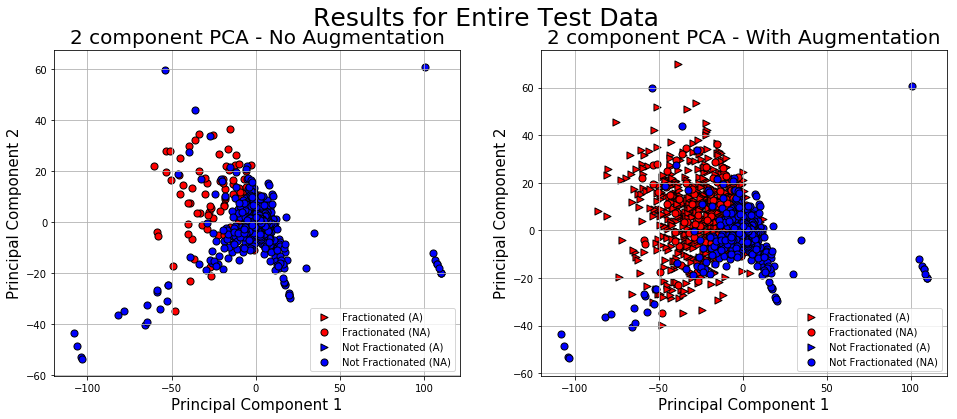

In [58]:
%matplotlib inline

pca = PCA(n_components=2)
principal_components_na = pca.fit_transform(X_na.values)
principal_df_na = pd.DataFrame(data = principal_components_na
             , columns = ['principal component 1', 'principal component 2'])

final_df_na = pd.concat([principal_df_na, info_na.reset_index()], axis = 1)

principal_components_a = pca.transform(X.values)
principal_df_a = pd.DataFrame(data = principal_components_a
             , columns = ['principal component 1', 'principal component 2'])

final_df_a = pd.concat([principal_df_a, info.reset_index()], axis = 1)

fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2) 
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA - No Augmentation', fontsize = 20)
labels = ['1', '0']
colors = ['r', 'b']
augmented = [1,0]
markers = ['o', '>']
for label, color in zip(labels,colors):
    for aug in augmented:
        idx_to_keep = ((final_df_na['Label 1'].values == label) & (final_df_na['Augmented'] == aug))
        ax1.scatter(final_df_na.loc[idx_to_keep, 'principal component 1']
                   , final_df_na.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , marker = markers[aug]
                   , edgecolors = 'k'
                   , s = 50)
ax1.legend(['Fractionated (A)', 'Fractionated (NA)', 
            'Not Fractionated (A)', 'Not Fractionated (NA)'])
ax1.grid()

ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('2 component PCA - With Augmentation', fontsize = 20)
labels = ['1', '0']
colors = ['r', 'b']
augmented = [1,0]
markers = ['o', '>']
for label, color in zip(labels,colors):
    for aug in augmented:
        idx_to_keep = ((final_df_a['Label 1'].values == label) & (final_df_a['Augmented'] == aug))
        ax2.scatter(final_df_a.loc[idx_to_keep, 'principal component 1']
                   , final_df_a.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , marker = markers[aug]
                   , edgecolors = 'k'
                   , s = 50)
ax2.legend(['Fractionated (A)', 'Fractionated (NA)', 
            'Not Fractionated (A)', 'Not Fractionated (NA)'])
ax2.grid()

plt.suptitle('Results for Entire Test Data', fontsize=25)
plt.show()

In [59]:
print(pca.components_)
print(X.columns)

[[-1.07249472e-03 -4.93318467e-03 -8.65000226e-01 -4.31178574e-02
  -9.39127237e-02 -1.42574782e-03 -5.40137078e-03 -4.90957396e-01]
 [ 1.55857665e-03 -6.75246250e-04 -5.01347409e-01  7.22381674e-02
   2.01092674e-01  1.30475232e-03  8.81600310e-03  8.38398384e-01]]
Index(['Approximate Entropy: m=3 r=0.7', 'Index Mass Quantile: q=0.6',
       'Location of Maximum Energy: M=14', 'Number of Peaks: set_thresh=False',
       'Percentage Fractionation: thresh=0.01', 'Ratio Beyond 1xSTD',
       'Sample Entropy Around Max Energy: width=60 r=0.025',
       'Width of Maximum Energy: M=14, width_thresh=0.2'],
      dtype='object')


In [5]:
# A shitty conduction delay detector
def get_delay(x, amp_thresh=None, set_thresh=False):
    if (set_thresh==True):
        if any(abs(x)>amp_thresh):
            return np.argmax(abs(x)>amp_thresh)
        else:
            return len(x)
    else:    
        return np.argmax(abs(x)>(max(abs(x))/2))
    
def denoise(x):
    # Obtain Daubechies N=6 wavelet coefficients
    waveletCoefs = pywt.wavedec(x, 'db7', mode='per')

    # Throw away coefficients corresponding to noise
    sigma = mad(waveletCoefs[-1])
    uThresh = 1*sigma*np.sqrt(2*np.log(len(x)))
    denoised = waveletCoefs[:]
    denoised[1:] = (pywt._thresholding.hard(i, value=uThresh) for i in denoised[1:])

    # Reconstruct the original signal
    xDenoised = pywt.waverec(denoised, 'db7', mode='per')

    return xDenoised

def get_peaks(x, height_thresh, scale_amp=None, set_scale=False, plot = False):
    x = np.array(x)
    
    # Get height_thresh
    if set_scale:
        height_thresh = height_thresh*scale_amp
    else:
        height_thresh = height_thresh*max(abs(x))
    
    # Denoise x
    xdn = denoise(x)

    # Detect peaks using detect_peaks
    pos_peak_idx = detect_peaks(xdn, mph=height_thresh, threshold = 0)
    neg_peak_idx = detect_peaks((-xdn), mph=height_thresh, threshold = 0)
    peak_idx = np.concatenate([pos_peak_idx, neg_peak_idx])
    peak_idx = np.sort(peak_idx)
    # Edge indeces aren't detected
    peak_idx = peak_idx[(peak_idx != 0) & (peak_idx != (len(xdn)-1))]

    new_peak_idx = []
    peak_amp = []
    if (len(peak_idx) > 0):
        new_peak_idx.append(peak_idx[0])
        mp_thresh = 0.2*max(abs(x))
        for i in range(len(peak_idx)-1):
            idx = peak_idx[i]
            idx_next = peak_idx[i+1]
            mid_point = int((idx_next+idx)/2)
            if (max([abs(x[idx_next]-x[mid_point]), abs(x[idx]-x[mid_point])]) > mp_thresh):
                new_peak_idx.append(idx_next)

        peak_idx = np.array(new_peak_idx)
        peak_amp = x[peak_idx]

    if plot == True:
        fig, [ax1] = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,8))
        ax1.plot(x, 'b' , xdn, 'r--', peak_idx, peak_amp, 'kx')
        #plt.title(fileName)
        ax1.set_xlabel('Sample')
        ax1.set_ylabel('Normalised amplitude')
        ax1.legend(['Original segment', 'Denoised segment', 'Detected peaks'])

        plt.draw()
        plt.waitforbuttonpress(0) # this will wait for indefinite time
        plt.close(fig)


    return peak_idx, peak_amp

def sample_entropy(U, m, r):

    def _maxdist(x_i, x_j):
        result = max([abs(ua-va) for ua, va in zip(x_i, x_j)])
        return result

    def _phi(m):
        x = np.zeros([N,m-1])
        for i in range(N-m+1):
            x[i,:] = U[i:i+m-1]

        C = 0
        for i in range(len(x)):
            for j in range(len(x)):
                if i != j:
                    if _maxdist(x[i,:], x[j,:]) <= r:
                        C = C + 1

        return C

    U = U/max(abs(U))
    N = len(U)

    return -np.log(_phi(m+1)/_phi(m))

def percentage_fractionation(x, peak_idxs, thresh=0.01, sr=1000):
    # Get peak indexes and amplitude
    peak_idx_diffs = np.diff(peak_idxs)
    frac_time = 0
    frac_time = np.sum(peak_idx_diffs[peak_idx_diffs < thresh*sr])
    prcnt_frac = (frac_time/len(x))*100
    return prcnt_frac

def get_local_sample_entropy(x, centre_idx, width, m=2, r=0.05):
    # Ensure width is odd
    if ((width%2) == 0):
        width += 1
        
    if (centre_idx < (width-1)/2):
        return sample_entropy(x[:width+1], m, r)
    elif (centre_idx > (len(x)-1-(width-1)/2)):
        return sample_entropy(x[len(x)-1-width:], m, r)
    else:
        return sample_entropy(x[int(centre_idx-(width-1)/2):int(centre_idx+(width+1)/2)], m, r)
    
def get_location_of_max_energy(x, M=14):
    v = np.ones(M)
    x_ = np.convolve(abs(x), v)
    return (np.argmax(x_) + math.floor(M/2))
        
def get_local_peaks(x, centre_idx, width=25, height_thresh=0.1):
    if ((width%2) == 0):
        width += 1
        
    if (centre_idx < (width-1)/2):
        return get_peaks(x[:width+1], height_thresh)
    elif (centre_idx > (len(x)-1-(width-1)/2)):
        return get_peaks(x[len(x)-1-width:], height_thresh)
    else:
        return get_peaks(x[int(centre_idx-(width-1)/2):int(centre_idx+(width+1)/2)], height_thresh)
    
def get_pse(x):
    x_fft = np.fft.rfft(x)
    x_P = (1/len(x_fft))*np.absolute(x_fft)**2
    x_p = x_P/sum(x_P)
    pse = np.sum([(-p*np.log2(p)) for p in x_p])
    return pse

def get_local_pse(x, centre_idx, width=50):
    if ((width%2) == 0):
        width += 1
        
    if (centre_idx < (width-1)/2):
        return get_pse(x[:width+1])
    elif (centre_idx > (len(x)-1-(width-1)/2)):
        return get_pse(x[len(x)-1-width:])
    else:
        return get_pse(x[int(centre_idx-(width-1)/2):int(centre_idx+(width+1)/2)])
    
def get_spectral_centroid(x):
    x_fft = np.fft.rfft(x)
    x_spectrum = np.absolute(x_fft)
    normalized_spectrum = x_spectrum/sum(x_spectrum)
    normalized_frequencies = np.arange(0, len(x_spectrum), 1)
    return sum(normalized_frequencies * normalized_spectrum)

def get_local_spectral_centroid(x, centre_idx, width=50):
    if ((width%2) == 0):
        width += 1
        
    if (centre_idx < (width-1)/2):
        return get_spectral_centroid(x[:width+1])
    elif (centre_idx > (len(x)-1-(width-1)/2)):
        return get_spectral_centroid(x[len(x)-1-width:])
    else:
        return get_spectral_centroid(x[int(centre_idx-(width-1)/2):int(centre_idx+(width+1)/2)])
    
def get_local_energy(x, centre_idx, width=60):
    if ((width%2) == 0):
        width += 1
        
    if (centre_idx < (width-1)/2):
        return np.sum(x[:width+1]**2)
    elif (centre_idx > (len(x)-1-(width-1)/2)):
        return np.sum(x[len(x)-1-width:]**2)
    else:
        return np.sum(x[int(centre_idx-(width-1)/2):int(centre_idx+(width+1)/2)]**2)
    
def get_width_max_energy(x, M=14, width_thresh=0.2):
    v = np.ones(M)
    x_ = np.convolve(abs(x), v)
    if any(x_[np.argmax(x_):] < width_thresh*np.max(x_)):
        end_idx = np.argmax(x_) + np.argmax(x_[np.argmax(x_):] < width_thresh*np.max(x_))
    else:
        end_idx = len(x_)-1
    if any(x_[np.argmax(x_)::-1] < width_thresh*np.max(x_)):  
        start_idx = np.argmax(x_) - np.argmax(x_[np.argmax(x_)::-1] < width_thresh*np.max(x_))
    else:
        start_idx = 0
    return (end_idx - start_idx)

In [6]:
def get_good_feature_dict(x, col_prefix=''):
    feature_dict = {}
    height_thresh=0.1
    
#     feature_dict[col_prefix + 'Maximum Absolute Value'] = max(abs(x))
    
    # Hand engineered features
    x = x/max(abs(x))
#     feature_dict[col_prefix + 'Conduction Delay: set_thresh=False'] = get_delay(x)
    peaks = get_peaks(x, height_thresh)
    feature_dict[col_prefix + 'Number of Peaks: set_thresh=False'] = len(peaks[0])
    feature_dict[col_prefix + 'Percentage Fractionation: thresh=0.01'] = percentage_fractionation(x, peaks[0], thresh=0.01)
    
    # Denoise x for remaining features
    x = denoise(x)
    max_energy_idx = get_location_of_max_energy(x)
    feature_dict[col_prefix + 'Location of Maximum Energy: M=14'] = max_energy_idx
    feature_dict[col_prefix + 'Sample Entropy Around Max Energy: width=60 r=0.025'] = get_local_sample_entropy(x, max_energy_idx, 60, m=2, r=0.025)
    feature_dict[col_prefix + 'Width of Maximum Energy: M=14, width_thresh=0.2'] = get_width_max_energy(x, M=14, width_thresh=0.2)
    
    # Temporal features
    feature_dict[col_prefix + 'Approximate Entropy: m=3 r=0.7'] = feature_calculators.approximate_entropy(x, 3, 0.7)
    imq = feature_calculators.index_mass_quantile(x, [{'q': 0.6}])
    feature_dict[col_prefix + 'Index Mass Quantile: q=0.6'] = imq[0][1]
    feature_dict[col_prefix + 'Ratio Beyond 1xSTD'] = feature_calculators.ratio_beyond_r_sigma(x, 1)
    
    # Spectral features
#     feature_dict[col_prefix + 'Power Spectral Entropy'] = get_pse(x)
    
    return feature_dict
    

def get_hand_engineered_feature_dict(x, thresh_cd=None, set_thresh_cd=False, thresh_peaks=None, set_thresh_peaks=False, show_peaks=False, col_prefix = ''):
    feature_dict = {}
    sf = max(abs(x))
    x = x/max(abs(x))

    # Hand engineered features
    if set_thresh_cd:
        thresh_cd = thresh_cd/sf
        feature_dict[col_prefix + 'Conduction Delay: set_thresh=True'] = get_delay(x, thresh_cd, set_thresh_cd)
        feature_dict[col_prefix + 'Conduction Delay: set_thresh=False'] = get_delay(x)
    else:
        feature_dict[col_prefix + 'Conduction Delay: set_thresh=False'] = get_delay(x)
    
    height_thresh=0.1
    if set_thresh_peaks:
        thresh_peaks = thresh_peaks/sf
        peaks = get_peaks(x, height_thresh, thresh_peaks, set_thresh_peaks, plot=False)
        feature_dict[col_prefix + 'Number of Peaks: set_thresh=True'] = len(peaks[0])
        peaks = get_peaks(x, height_thresh)
        feature_dict[col_prefix + 'Number of Peaks: set_thresh=False'] = len(peaks[0])
    else:
        peaks = get_peaks(x, height_thresh)
        feature_dict[col_prefix + 'Number of Peaks: set_thresh=False'] = len(peaks[0])
    
    peaks = get_peaks(x, height_thresh)
    feature_dict[col_prefix + 'Percentage Fractionation: thresh=0.01'] = percentage_fractionation(x, peaks[0], thresh=0.01)
    
    # Denoise x for remaining features
    x = denoise(x)
    
    max_energy_idx = get_location_of_max_energy(x)
    feature_dict[col_prefix + 'Location of Maximum Energy: M=14'] = max_energy_idx
    feature_dict[col_prefix + 'Sample Entropy Around Max Energy: width=60 r=0.025'] = get_local_sample_entropy(x, max_energy_idx, 60, m=2, r=0.025)
    feature_dict[col_prefix + 'Energy Around Max Energy'] = get_local_energy(x, max_energy_idx, 60)
    min_idx = np.argmin(x)
    max_idx = np.argmax(x)
    feature_dict[col_prefix + 'Peaks Between Min and Max'] = len([i for i in peaks[0] if ((i > min_idx) & (i < max_idx))])
    feature_dict[col_prefix + 'Width of Maximum Energy: M=14, width_thresh=0.4'] = get_width_max_energy(x, M=14, width_thresh=0.4)
    feature_dict[col_prefix + 'Width of Maximum Energy: M=14, width_thresh=0.2'] = get_width_max_energy(x, M=14, width_thresh=0.2)

    return feature_dict

def get_spectral_feature_dict(x, col_prefix = ''):
    feature_dict = {}
    # Denoise and normalise x for remaining features
    x = denoise(x)
    x = x/max(abs(x))
    
    feature_dict[col_prefix + 'Power Spectral Entropy'] = get_pse(x)
    feature_dict[col_prefix + 'Spectral Centroid'] = get_spectral_centroid(x)
    max_energy_idx = get_location_of_max_energy(x)
    feature_dict[col_prefix + 'Power Spectral Entropy Around Maximum Energy: width=30'] = get_local_pse(x, max_energy_idx, width=30)
    feature_dict[col_prefix + 'Spectral Centroid Around Maximum Energy: width=30'] = get_local_spectral_centroid(x, max_energy_idx, width=30)
    feature_dict[col_prefix + 'Power Spectral Entropy Around Maximum Energy: width=60'] = get_local_pse(x, max_energy_idx, width=60)
    feature_dict[col_prefix + 'Spectral Centroid Around Maximum Energy: width=60'] = get_local_spectral_centroid(x, max_energy_idx, width=60)
    
    return feature_dict
    
def get_temporal_feature_dict(x, col_prefix = ''):

    feature_dict = {}
    feature_dict[col_prefix + 'Maximum Absolute Value'] = np.max(abs(x))
    
    # Denoise and normalise x for remaining features
    x = denoise(x)
    x = x/max(abs(x))


    erbc = feature_calculators.energy_ratio_by_chunks(x, [{'num_segments':10, 'segment_focus':3}, {'num_segments':10, 'segment_focus':2}])
    feature_dict[col_prefix + 'Energy Ratio by Chunks: num_segments=10 segment_focus=2'] = erbc[1][1]
    feature_dict[col_prefix + 'Energy Ratio by Chunks: num_segments=10 segment_focus=3'] = erbc[0][1]
    feature_dict[col_prefix + 'Approximate Entropy: m=3 r=0.7'] = feature_calculators.approximate_entropy(x, 3, 0.7)
    feature_dict[col_prefix + 'Ratio Beyond 5xSTD'] = feature_calculators.ratio_beyond_r_sigma(x, 5)
    feature_dict[col_prefix + 'Ratio Beyond 4xSTD'] = feature_calculators.ratio_beyond_r_sigma(x, 4)
    feature_dict[col_prefix + 'Ratio Beyond 3xSTD'] = feature_calculators.ratio_beyond_r_sigma(x, 3)
    feature_dict[col_prefix + 'Ratio Beyond 2xSTD'] = feature_calculators.ratio_beyond_r_sigma(x, 2)
    feature_dict[col_prefix + 'Ratio Beyond 1xSTD'] = feature_calculators.ratio_beyond_r_sigma(x, 1)
    # A fraction q of the mass lies to the left of i. (Alternative to conduction delay?)
    imq = feature_calculators.index_mass_quantile(x, [{'q': 0.6}, {'q': 0.4}])
    feature_dict[col_prefix + 'Index Mass Quantile: q=0.6'] = imq[0][1]
    feature_dict[col_prefix + 'Index Mass Quantile: q=0.4'] = imq[1][1]
    

    return feature_dict

In [7]:
def augment_fractionation(x, N, only_mag=False, debug=False):
    # Jittering
    def jitter(x, sigma=0.05):
        my_noise = np.random.normal(loc=0, scale=sigma, size=len(x))
        return x+my_noise

    # Scaling
    def scaling(x, sigma=0.1):
        scaling_factor = np.random.normal(loc=1.0, scale=sigma)
        return x*scaling_factor

    def generate_random_curves(x, sigma=0.2, knot=50):
        xx = np.arange(0,len(x), (len(x)-1)/(knot+1))
        yy = np.random.normal(loc=1.0, scale=sigma, size=knot+2)

        x_range = np.arange(len(x))
        cs = CubicSpline(xx, yy)

        return np.array(cs(x_range))

    # Magnitude warping
    def magwarp(x, sigma):
        cs = generate_random_curves(x, sigma, knot=25)
        # Blend cs curve towards 1 at both ends
        # tau = 10
        # delta = int(np.floor(len(x)/2))
        # for i in range(delta):
        #     cs[i] = (1-np.exp(-i/tau))*cs[i] + np.exp(-i/tau)*0
        #     cs[-(i+1)] = (1-np.exp(-i/tau))*cs[-(i+1)] + np.exp(-i/tau)*0

        return x*cs

    def distort_timesteps(x, sigma=0.2):
        tt = generate_random_curves(x, sigma, knot=7) # Regard these samples aroun 1 as time intervals
        tt_cum = np.cumsum(tt)        # Add intervals to make a cumulative graph
        # Make the last value to have X.shape[0]
        t_scale = (len(x)-1)/tt_cum[-1]
        tt_cum = tt_cum*t_scale
        return tt_cum

    # Time warping
    def timewarp(x, sigma=0.2):
        tt_new = distort_timesteps(x, sigma)
        x_new = np.zeros(len(x))
        x_range = np.arange(len(x))
        x_new = np.interp(x_range, tt_new, x)
        return x_new

    # Rotation
    def rotation(x):
        axis = np.random.uniform(low=-1, high=1, size=1)
        angle = np.random.uniform(low=-np.pi, high=np.pi)
        return np.matmul(x , axangle2mat(axis,angle))


    # x = x/max(abs(x))   # Normalise
    x_aug = np.zeros([N, len(x)])

    # Create N augmented examples
    if only_mag == False:
        for i in range(0,N):
            x_aug[i,:] = timewarp(x, 0.2)
            # x_aug[i,:] = timewarp(x_aug[i,:], 0.2)
            # x_aug[i,:] = timewarp(x_aug[i,:], 0.2)
            # x_aug[i,:] = magwarp(x_aug[i,:], 0.2)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.1)
            x_aug[i,:] = timewarp(x_aug[i,:], 0.2)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.2)
            # x_aug[i,:] = x_aug[i,:]/max(abs(x_aug[i,:]))
            x_aug[i,:] = timewarp(x_aug[i,:], 0.2)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.2)
            x_aug[i,:] = timewarp(x_aug[i,:], 0.2)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.2)
    else:
         for i in range(0,N):
            x_aug[i,:] = magwarp(x, 0.2)
            # x_aug[i,:] = timewarp(x_aug[i,:], 0.2)
            # x_aug[i,:] = timewarp(x_aug[i,:], 0.2)
            # x_aug[i,:] = magwarp(x_aug[i,:], 0.2)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.1)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.2)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.1) 
            x_aug[i,:] = magwarp(x_aug[i,:], 0.1)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.2)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.1) 
            x_aug[i,:] = magwarp(x_aug[i,:], 0.1)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.2)
            x_aug[i,:] = magwarp(x_aug[i,:], 0.1) 


    if ((debug==True) & (N>3)):
        fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(4,6))
        ax1.plot(x)
        ax1.axis('off')
        for i, ax in enumerate([ax2, ax3, ax4, ax5]):
            ax.plot(x/max(abs(x)), '--', alpha=0.5)
            ax.hold(True)
            ax.plot(x_aug[i,:]/max(abs(x_aug[i,:])))
            ax.axis('off')

        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        plt.draw()
        plt.waitforbuttonpress()
        plt.close(fig)

    return x_aug